# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
#import the library that provides us with mathematical tools
import numpy as np

#import the library that provides us with neural network tools
import torch 

from torch import nn
from torch import optim

#import torch.nn.functional as F

#import the library that enables us to load images and transform the images to vectors and download the pre-trained model 
#we want to use
from torchvision import datasets, transforms,models

#import udacity helper.py to view images
import helper

from workspace_utils import keep_awake

from datetime import datetime
from workspace_utils import active_session

from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

#https://pytorch.org/vision/stable/transforms.html
#Since v0.8.0 all random transformations are using torch default random generator to sample random parameters. 
#It is a backward compatibility breaking change and user should set the random state as following
#torch.manual_seed(17)

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: load the images into a pandas dataframe 

#image_datasets = pd.DataFrame({'train':})


In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
# train: we need to COMPOSE a transform that performs random scaling, cropping, flipping and resizing (to 224x224)
# normalise the images by passing in the list of means and std
tfrm_train = transforms.Compose([transforms.RandomVerticalFlip(),
                                 transforms.RandomResizedCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485,0.456,0.406],
                                                      [0.229, 0.224, 0.225])])

# train/validation: we need to COMPOSE a transform that resizes and then crops image to 224x224 and normalises the colours
#(which is what the pre-trained network we'll be using expects) (validation dataset needs to look similar to the dataset)
tfrm_testvalid = transforms.Compose([transforms.Resize(255)
                                        ,transforms.CenterCrop(224)
                                        ,transforms.ToTensor()
                                        ,transforms.Normalize([0.485,0.456,0.406],
                                                              [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
#image_datasets: make it a pandas dataframe of datasets, so image_datasets['train'], image_datasets['valid'] etc
#tell torchvision where the images are and how to transform them
imgset_train = datasets.ImageFolder(train_dir,transform=tfrm_train)
imgset_test =  datasets.ImageFolder(test_dir,transform=tfrm_testvalid)
imgset_valid =  datasets.ImageFolder(valid_dir,transform=tfrm_testvalid)

# TODO: Using the image datasets and the trainforms, define the dataloaders, just shuffle the TRAINING set
loader_train = torch.utils.data.DataLoader(imgset_train,batch_size=32,shuffle=True)
loader_test = torch.utils.data.DataLoader(imgset_test,batch_size=32,shuffle=False) 
loader_valid = torch.utils.data.DataLoader(imgset_valid,batch_size=32,shuffle=False) 


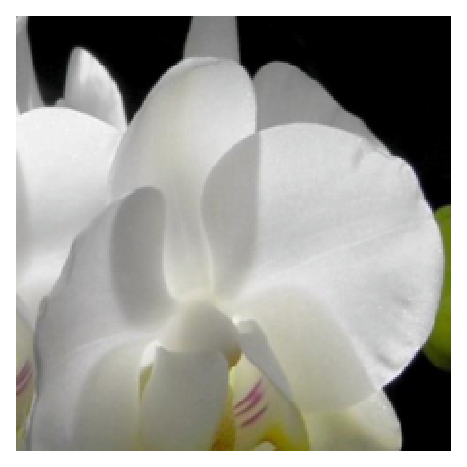

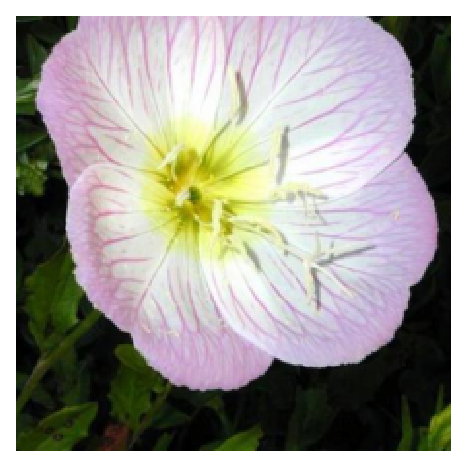

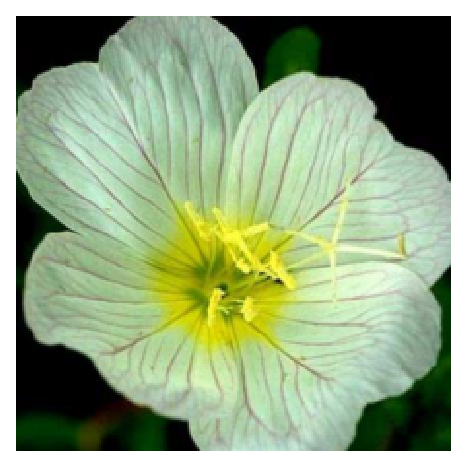

In [4]:
#test the data loader: note because we've normalised the data during the transform, specify "normalise=True"
images, labels = next(iter(loader_train))
helper.imshow(images[0],normalize=True) #should see a different one each time: shuffle is on

images, labels = next(iter(loader_test))
helper.imshow(images[0],normalize=True) #should see the same image each time

images, labels = next(iter(loader_valid))
helper.imshow(images[0],normalize=True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

#the folder categories are numeric; this provides the translation of the number to an actual flower name
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [6]:
def define_model(classname,name,freeze_model,verbose=True):
    '''
    Define the model to be used
        classname vgg
        name vgg16
        freeze_model 1 if parameters are to be frozen
    Returns
        model with appropriate image classifier structure assigned
        attribute classname populated
        attribute name populated
        attribute input_size populated
    '''
    #download the pre-trained model we want to use and retrieve the number of input_features the model is 
    #trained for, store this as a model attribute
    if name=='vgg16':
        model = models.vgg16(pretrained=True)

    #store the type of model being used
    model.classname = classname
    model.name = name
    
    # different models are structured in slightly different ways and the number of input features is
    # pre-set for the trained model
    if model.classname == "densenet":
        model.input_size = model.classifier.in_features
    elif model.classname == "vgg":
        model.input_size = model.classifier[0].in_features
    elif model.classname == "resnet":
        model.input_size = model.fc.in_features
    
    if verbose==True:
        print("Model downloaded")
    
    if freeze_model == 1:
        for parameter in model.parameters():
                parameter.requires_grad = False
        else: #one the for loop is finished, do this.  Odd syntax, not sure why indenting isn't sufficient.
            if verbose==True:
                print("Model features frozen")  
    
    return model

In [17]:
def assign_classifier(model,output_size=102,hidden_units=512, drop_out=0.2,verbose=True):
    '''
    Define the image classification to be processed by the model.  
        model: the pretrained model to be used
        output_size: the number of classes the model should be able to predict
        hidden_units: 
        drop_out: the probabiity of neuron being "dropped" during classification
    Returns
        model with appropriate image classifier structure assigned
        attribute drop_out populated
        attribute hidden_units populated
    '''
    classifier = nn.Sequential(
               nn.Linear(model.input_size, hidden_units),  
               nn.ReLU(),
               nn.Dropout(drop_out),
               nn.Linear(hidden_units, output_size),
               nn.LogSoftmax(dim=1))

    # attach the classifier to the model
    if model.classname =="vgg":
        model.classifier = classifier
        model.classifier_name= "classifier"
    #elif model.classname=="densenet":
    #    model.classifier = classifier
    elif model.classname=="resnet":
        model.fc = classifier
        model.classifier_name= "fc"
    
    # store the attributes to simplify the checkpoint restoration
    model.drop_out = drop_out
    model.hidden_units= hidden_units
    model.output_size=output_size
    
    if verbose==True:
        print("Model classifier assigned")
    return model

In [10]:
def assign_optimiser(model,learningrate = 0.001,verbose=True):
    '''
    Define the optimiser to be used the model.  
        model: the pretrained model to be used, with assigned classifier
        lr: the learning rate to be used by the optimiser
    Returns
        optimiser appropriate to model assigned with specified learning rate
    '''
    # define the optimiser to use, using our classifier parameters and a learning rate
    if model.classname == "resnet":
        optimiser = optim.Adam(model.fc.parameters(), lr=learningrate)
    elif model.classname == "vgg":
        optimiser = optim.Adam(model.classifier.parameters(), lr=learningrate)
  
    if verbose==True:
        print("Model optimiser assigned")
        
    return optimiser

In [12]:
# TODO: evaluate the test set
def evaluate_model(model,loader_img,criterion):
    '''
    Run the model in evaluation mode to see how the model is performing on the image set passed
        model: the model to use, assigned with the appropriate classifier
        criterion: the loss method to use during this run
        loader_img: the images to evaluate
    Returns
        list of results:
            0 = evaluation loss
            1 = evaluation accuracy
    '''
    loss = 0
    accuracy = 0

    model.eval() #put the model into "evaluation" mode

    with torch.no_grad(): #we're not updating weights during the evaluation pass, so turn this off

        #for each image in the loader set, calculate the loss of the current
        #batch of images and determine the accuracy of this batch
        for imgs,lbls in loader_img:

            #move the images and labels to the device being used to process
            imgs,lbls = imgs.to(device),lbls.to(device)

            #do a forward pass with the current batch of images and get log
            #probabilities associated with each image
            lps = model.forward(imgs)
            
            #x = imgs.shape
            #y=type(imgs)
            #z=imgs.type()
            
            #calculate the error (i.e. what the model said vs the known label of the images)
            batch_loss = criterion(lps,lbls)

            #add the batch loss for this step to the total loss for the images
            #so we can track it
            loss +=batch_loss.item()

            #determine accuracy, get the exponential of the probabilites (because the model is 
            #returning softmax probabilities which are log probabilites) 
            prob = torch.exp(lps)

            #get the most likely class that's been assigned to the image with the 
            #highest probability of being correctly classified
            top_prob, top_class = prob.topk(1, dim=1)

            #determine whether the most likely class IS classified correctly
            equals = top_class == lbls.view(* top_class.shape)

            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
    #return the results as a list
    results = [loss/len(loader_img)]
    results.append(accuracy/len(loader_img)*100)
    return results


In [20]:
def train_model(model, optimiser, criterion, loader_train, loader_valid, epochs):
    ''' 
    Trains the model using the training imageset and validates against the validation imageset
        model: the model to use, assigned with the appropriate classifier
        optimiser: the optimiser to use during this run
        criterion: the loss method to use during this run
        loader_train: the training images
        loader_valid: the validation images
        epochs: the number of epochs to train the network with
    '''

    # create the training iterations and validate the training against the validation images
    steps = 0 #keep track of the number of steps
    train_running_loss = 0 #keep track of the loss
    print_step = 20 #print a message every n steps which will provide information on how well the model is currently working
                    #if we run it against the validation dataset (i.e. validate the trained model with a set of validation images)

    
    for epoch in range(epochs):
            for train_imgs, train_lbls in loader_train:
                    steps+= 1

                    # move the training images and their labels (the folder name or category) to the device
                    train_imgs, train_lbls = train_imgs.to(device), train_lbls.to(device)

                    #zero the gradients so that they don't accumulate through the training loop
                    optimiser.zero_grad()

                    # get the log probabilities from the training images and calculate the loss for this iteration
                    train_lps = model.forward(train_imgs)
                    
                    #get the loss between what the model thinks the image is and what the image ACTUALLY is
                    train_loss = criterion(train_lps,train_lbls)
                    
                    #apply the weights back through the network
                    train_loss.backward()

                    #take a step down the mountain
                    optimiser.step()

                    train_running_loss += train_loss.item()

                    if steps % print_step == 0:
                        
                        # conduct a validation of the training so far
                        results = evaluate_model(model, loader_valid,criterion)
                                
                        print("Epoch: {}/{} ".format(epoch+1,epochs),
                              "Training Loss: {:.3f} ".format(train_running_loss/print_step),
                              "Validation Loss: {:.3f} ".format(results[0]),
                              "Validation Accuracy: {:.2f}%".format(results[1]))
                        
                        #reset to train the next batch of images during the next step
                        train_running_loss = 0
                        
                        #put the model back into "train" mode
                        model.train() 
    
    print("Training complete")
                            

In [14]:
def load_checkpoint(filepath,device,verbose=True):

    # load the stored checkpoint dictionary in GPU or CPU mode, as appropriate as per 
    # https://knowledge.udacity.com/questions/42098
    checkpoint = torch.load(filepath,map_location=str(device))
    
    # define the model using the information from the checkpoint and freeze the gradient.  
    # this also retrieves the number of input features the model is expecting based on the model class name
    # (i.e. pre-trained models have different structures in terms of input_size [(]number of input features])
    model = define_model(checkpoint['classname'],checkpoint['name'],1)
    
    # move the model to either the cpu or the gpu as appropri
    model.to(device)
    
    # retrive values for the dictionary, assigning default if the checkpoint file is not populated    
    output_size = checkpoint.get('output_size',102)
    hidden_units = checkpoint.get('hidden_units',512)
    drop_out = checkpoint.get('drop_out',0.2)
    epochs = checkpoint.get('epochs',1)
    
    #assign the classifier as per the checkpoint file
    model = assign_classifier(model,output_size,hidden_units,drop_out)
    
    model.epochs=epochs 
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    #not sure we have to worry about the optimiser?
    #optimiser = assign_optimiser(model,0.001)

    # restore the classification stored with the model, i.e. the classification category that each index number represents
    model.class_to_idx=checkpoint['class_to_idx']
    
    #optimiser.load_state_dict(checkpoint['optimser_state_dict'])
    
    if verbose==True:
        print("Model name: {}".format(model.name))
        print("Model class: {}".format(model.classname))
        print("input_size: {}".format(model.input_size))
        print("output_size: {}".format(model.output_size))
        print("hidden_units: {}".format(model.hidden_units))
        print("drop_out: {}".format(model.drop_out))
        print("epochs: {}".format(model.epochs))
        print("classifier: {}".format(getattr(model,model.classifier_name)))
        print("classifier_name: {}".format(model.classifier_name))
        print("class_to_idx: {}".format(model.class_to_idx))
   
    #return the results as a list
    result = [model]
    #result.append (optimiser)
    result.append (epochs)
    
    return result


In [14]:
def save_checkpoint(model,epochs,filepath):

    if model.classname=='vgg':
        checkpoint = {'classname':model.classname,
                      'name':model.name,
                      'input_size': model.input_size,
                      'output_size': 102,#model.output_size,
                      'drop_out':model.drop_out,
                      'hidden_units':model.hidden_units,
                      'epochs':epochs,
                      #'generic_classifier':model.classifier,
                      'classifier':model.classifier,
                      'classifier_name':"classifier",
                      'class_to_idx': model.class_to_idx,
                      'model_state_dict': model.state_dict(),
                      #'optimiser_state_dict': optimiser.state_dict
                     }
    elif model.classname=='resnet':
        checkpoint = {'classname':model.classname,
                      'name':model.name,
                      'input_size': model.input_size,
                      'output_size': 102,#model.output_size,
                      'drop_out': model.drop_out,
                      'hidden_units': model.hidden_units,
                      'epochs':epochs,
                      'fc':model.fc,
                      #'generic_classifier':model.fc,
                      'classifier_name':"fc",
                      'class_to_idx': model.class_to_idx,
                      'model_state_dict': model.state_dict(),
                      #'optimiser_state_dict': optimiser.state_dict
                     }

    torch.save(checkpoint, filepath)


## Load a model from the checkpoint file or configure a new model for training



In [18]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the model to use, or load it from a checkpoint
path = ''#'checkpoint_10_4_2100.pth'

if path=='':

    number_of_features = 102
    hidden_units = 512
    drop_out = 0.2
    
    # defining and training a new model
    model = define_model('vgg','vgg16',1)

    # move the configured model to the appropriate device
    model.to(device)
    
    model = assign_classifier(model,number_of_features,hidden_units,drop_out,True)

    #assign the optimiser to the model
    optimiser = assign_optimiser(model,0.001)    

    # define the loss using negative likelihood of loss
    criterion = nn.NLLLoss()

    # write the indexes that represent each class to the model so we can checkpoint them later
    model.class_to_idx = imgset_train.class_to_idx

    print ("Model is configured and ready for training and validation")    
else:
    # loading an existing model from a checkpoint file
    result = load_checkpoint(path,device)
    
    model = result[0]
    epochs = result[1]

    print ("Model is configured from checkpoint file and ready for predictions")    

    
#look at architecture of model
#model

Model downloaded
Model features frozen
Model classifier assigned
Model optimiser assigned
Model is configured and ready for training and validation


## Train the Model (if not loaded from checkpoint file)

In [21]:
#train the model
epochs = 2

print ("Start time: {}".format(datetime.now().strftime("%d/%m/%Y %H:%M:%S")))


if str(device) == "cuda":
    with active_session():
        train_model(model, optimiser,criterion, loader_train,loader_valid,epochs)
else:
    #print("Enable GPU mode")
    train_model(model, optimiser,criterion, loader_train,loader_valid,epochs)

print ("End time: {}".format(datetime.now().strftime("%d/%m/%Y %H:%M:%S")))
    

Start time: 04/05/2021 07:46:17


UnboundLocalError: local variable 'train_imgs' referenced before assignment

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [17]:
# test the model
print ("Start time: {}".format(datetime.now().strftime("%d/%m/%Y %H:%M:%S")))

if str(device) == "cuda":
    with active_session():
        results = evaluate_model(model, loader_test,criterion)
else:
    #print("Enable GPU mode")
    results = evaluate_model(model, loader_test,criterion)

    
print("Validation Loss: {:.3f} ".format(results[0]),
      "Validation Accuracy: {:.2f}%".format(results[1]))

print ("End time: {}".format(datetime.now().strftime("%d/%m/%Y %H:%M:%S")))




Start time: 10/04/2021 11:30:35
image tensor type and shape: <class 'torch.Tensor'>, torch.Size([19, 3, 224, 224]), torch.cuda.FloatTensor
Validation Loss: 0.549  Validation Accuracy: 86.56%
End time: 10/04/2021 11:30:55


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [18]:
#save a checkpoint
save_checkpoint(model,epochs,'checkpoint_10_4_2100.pth')

print("checkpoint saved")

checkpoint saved


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [30]:
from PIL import Image

def process_image(image,crop_size=224,verbose=False):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a 3D Torch tensor (channel,width,height)
        
        image: the path to the image file
        crop_size: the size to crop the image
        verbose: whether to see the size of the images reported as processing proceeds
        
        PIL resource:https://auth0.com/blog/image-processing-in-python-with-pillow/
    '''
    # get the image object
    im = Image.open(image)
       
    #the shortest size should be 256 pixels
    short_target = 256
    
    # get the image size (tuple, width,height)
    if verbose==True:
        print("original size: {}".format(im.size))
    
    # resize the image to 256, maintaining aspect ratio (PIL thumbnail method maintains aspect ratio)
    im.thumbnail((short_target,short_target))

    if verbose==True:
        print ("resized to: {}".format(im.size))
      
    # work out the box that represents the area to be cropped (left, upper, right, lower)
    # (note the image may be shorter than 224 on one side, but the image will contain black space)
    left = 0.5 * im.size[0] - (crop_size / 2)
    right = 0.5 * im.size[0] + (crop_size / 2)
        
    top = 0.5 * im.size[1] - (crop_size / 2)
    bottom = 0.5 * im.size[1] + (crop_size / 2)
        
    box = (left, top, right, bottom)

    # crop out the center 224 x 224 of the image
    crop_im=im.crop(box)
    if verbose==True:
        print ("cropped size: {}".format(crop_im.size))
    
    #convert the image to a np array(3d of integers representing colours (RGB)) but 
    #convert to floats between 0 and 1
    np_image = (np.array(crop_im) / 256).astype(np.float)
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std 

    # move colour (3d) to 1d.
    np_image = np_image.transpose((2, 0, 1))
     
    #convert np array to torch tensor
    return torch.Tensor(np_image)  #this returns a torch.FloatTensor (which we need!)
    #return torch.from_numpy(np_image) #this returns a torch.DoubleTensor


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [31]:
def imshow(image, ax=None, title=None):
    """
    Display the tensor as an image
        
        image: torch.tensor
        ax: a subplot
        title: the title of the subplot
    
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    if title is not None:
        fig.suptitle(title)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

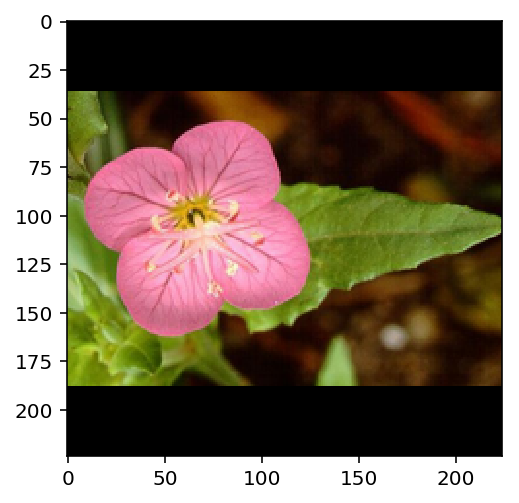

In [32]:
#get Tensor image
image = process_image("./flowers/test/1/image_06760.jpg")
#print("image type and shape: {},{},{}".format(type(image),image.shape,image.type()))

# show the Tensor image
imshow(image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [141]:
def predict(image_path, model, topk=5):
    ''' 
    Predict the class (or classes) of an image using a trained deep learning model.
        image_path: the path to the image we want to predict against the model
        model: the model we want to use to make the prediction
        topk: the number of predictions we want to return, ordered by probability
        
    returns:
        top_p ndarray: the top probabilities, ordered by probability
        top_class ndarray: the class index of each of the top probabilities
    '''
    
    #put the model into evaluation mode
    model.eval()
    
    #get the image as a 3D pytorch tensor
    img = process_image(image_path)
   
    # move the image to the device
    img = img.to(device)

    # process image returns a tensor with three dimensions (e.g. 3,244,244) - it's missing batch, so add that in
    img.unsqueeze_(0) #as per https://knowledge.udacity.com/questions/315033
    
    # calculate the probabilities
    with torch.no_grad():        
        output = model.forward(img)
        
    # the log probabilities are output (GPU)
    probabilities = torch.exp(output)
    
    # return the requested number of probabilities and their associated classes
    top_p,top_class = torch.topk(probabilities,topk,dim=1)
    
    # convert the model classes (folder names) to the index used in the json file
    idx_to_class = {val:key for key,val in model.class_to_idx.items()}

    #construct the class names from the top classes returned by the model converted to the index in the json file
    names = []
    for c in top_class.tolist()[0]: # for each of the identified classes
        names.append(cat_to_name[idx_to_class[c]])
    
    # convert them to cpu data types
    top_p = top_p.cpu()
    top_class = top_class.cpu()
    
    # return as numpy arrays
    return top_p.numpy(), top_class.numpy(),names
    
       

In [142]:
#path = 'checkpoint_7_4_1942.th'
#model = load_checkpoint(path)
top_p,top_class,names = predict("./flowers/test/1/image_06743.jpg", model)

print("top class {}".format(top_class))

# convert the model classes (folder names) to the index used in the json file
#idx_to_class = {val:key for key,val in model.class_to_idx.items()}

#construct the class names from the top classes returned by the model converted to the index in the json file
#names = []
#for c in top_class.tolist()[0]: # for each of the identified classes
#    names.append(cat_to_name[idx_to_class[c]])
    
print("flower names for top classes: {}".format(names))

#names2=np.array(names)
#print(names2)
#names = np.array(names)

#print(names[0:])
#print (top_p*100)





top class [[  0  84  49 100  76]]
flower names for top classes: ['pink primrose', 'hibiscus', 'petunia', 'mexican petunia', 'morning glory']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [135]:
def sanity_checking(image_path, probabilities, names):
    
    # create a figure that has two sub-plots, ax1 (the image) and ax2 (the barchart)
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1)

    # get the image as a pytorch tensor
    image = process_image(image_path)

    # display the tensor as an image on ax1
    imshow(image, ax=ax1)
    
    ax1.set_title(names[0])
    ax1.axis('off')
    
    # Display horizontal bar chart
    ax2.set_title("Flower Prediction Probability (%)")
    ax2.barh(names, probabilities*100)

    ax2.set_xlabel("Probability (%)")
    ax2.set_ylabel("Flower")
    ax2.set_xlim(0,110) #force x to show 0 to 100%

    plt.show()

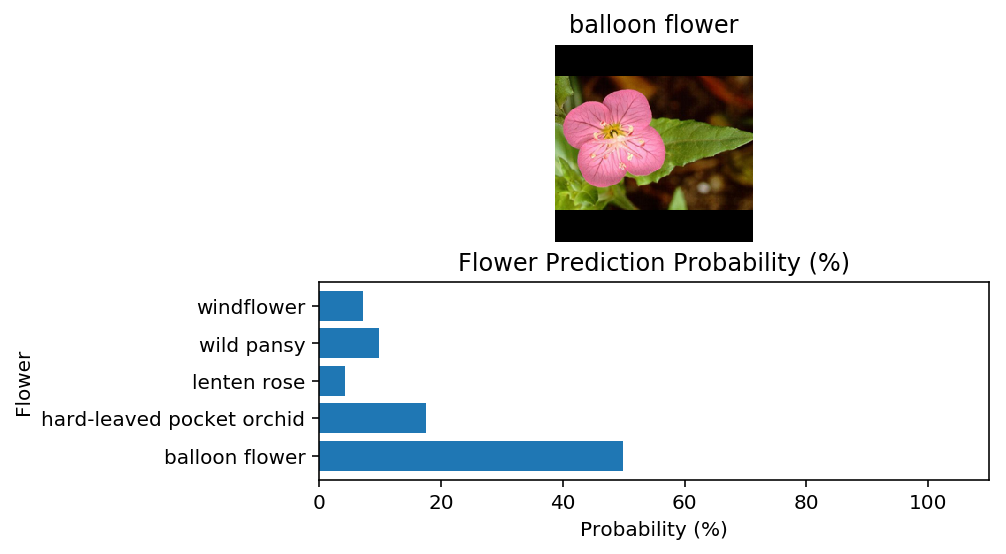

Based on folder name the image should be classified as pink primrose


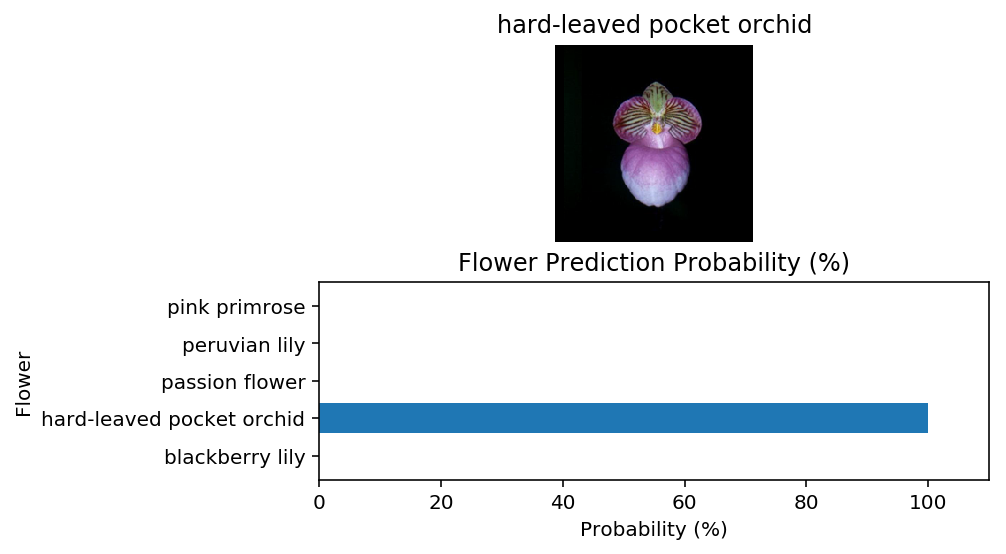

Based on folder name the image should be classified as hard-leaved pocket orchid


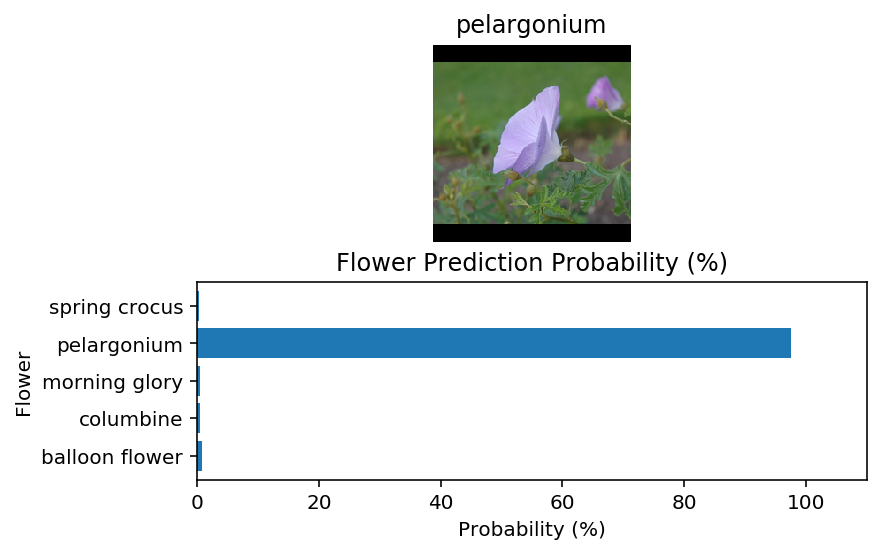

Based on folder name the image should be classified as pelargonium


In [146]:
filename="./flowers/test/1/image_06760.jpg"
top_p,top_class,names = predict(filename, model)
sanity_checking(filename,top_p[0],names)
print("Based on folder name the image should be classified as {}".format(cat_to_name['1']))

filename="./flowers/test/2/image_05100.jpg"
top_p,top_class,names = predict(filename, model)
sanity_checking(filename,top_p[0],names)
print("Based on folder name the image should be classified as {}".format(cat_to_name['2']))

filename="./flowers/test/55/image_04701.jpg"
top_p,top_class,names = predict(filename, model)
sanity_checking(filename,top_p[0],names)
print("Based on folder name the image should be classified as {}".format(cat_to_name['55']))